In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
board = cv2.aruco.CharucoBoard((5, 5), 0.08, 0.06, aruco_dict)

def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners) > 0:
            for corner in corners:
                cv2.cornerSubPix(gray, corner, winSize=(3, 3), zeroZone=(-1, -1), criteria=criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1]) > 3 and decimator % 1 == 0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator += 1   

    imsize = gray.shape
    return allCorners, allIds, imsize

def calibrate_camera(allCorners, allIds, imsize, cameraMatrixInit):   
    """
    Calibrates the camera using the detected corners.
    """
    distCoeffsInit = np.zeros((5, 1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
    # flags = (cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
        charucoCorners=allCorners,
        charucoIds=allIds,
        board=board,
        imageSize=imsize,
        cameraMatrix=cameraMatrixInit,
        distCoeffs=distCoeffsInit,
        flags=flags,
        criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

cameraMatrixInit : 
 [[1.36377332e+03 0.00000000e+00 9.56298462e+02]
 [0.00000000e+00 1.36157141e+03 5.46581238e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
POSE ESTIMATION STARTS:
=> Processing image ./images/calib/camera1_rgb/7.png
=> Processing image ./images/calib/camera1_rgb/4.png
=> Processing image ./images/calib/camera1_rgb/6.png
=> Processing image ./images/calib/camera1_rgb/2.png
=> Processing image ./images/calib/camera1_rgb/3.png
=> Processing image ./images/calib/camera1_rgb/5.png
=> Processing image ./images/calib/camera1_rgb/1.png
=> Processing image ./images/calib/camera1_rgb/8.png
Camera matrix : 
 [[1.39560139e+03 0.00000000e+00 9.47629450e+02]
 [0.00000000e+00 1.39334809e+03 5.01273728e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 5.16343216e+00]
 [ 5.25707634e+01]
 [ 2.88671630e-04]
 [-2.52339282e-03]
 [-1.27296122e+02]
 [ 5.17115476e+00]
 [ 5.03439686e+01]
 [-1.19817256e+02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e

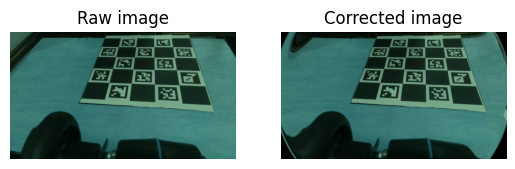

In [3]:
datadir = "./images/calib/camera1_rgb/"
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".png")])

cameraMatrixInit = np.load("./images/calib/camera1_params.npz")['color_intrinsics']
print("cameraMatrixInit : \n {0}".format(cameraMatrixInit))

allCorners, allIds, imsize = read_chessboards(images)
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners, allIds, imsize, cameraMatrixInit)

print("Camera matrix : \n {0}".format(mtx))
print(dist)

# check calibration
i=1
plt.figure()
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()